In [2]:
import os.path

file_path = '/Volumes/EXTERNALHDD/traces_disk_2/final_data_files/data_1.parquet'

In [3]:
import pandas as pd

edges_df = pd.read_parquet(file_path)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/EXTERNALHDD/traces_disk_2/final_data_files/data_1.parquet'

In [19]:
edges_df

,u,i,ts,idx,rt,0,1,2,3,4
3797497,17684,18738,60000,3797498,1.0,0.0,0.0,1.0,0.0,0.0
3797498,35482,19355,60000,3797499,0.0,0.0,0.0,0.0,0.0,1.0
3797499,18679,59226,60000,3797500,1.0,0.0,0.0,1.0,0.0,0.0
3797500,33545,14046,60000,3797501,0.0,0.0,0.0,1.0,0.0,0.0
3797501,969,17869,60000,3797502,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7393462,10077,35136,119999,7393463,0.0,0.0,0.0,1.0,0.0,0.0
7393463,44631,44354,119999,7393464,1.0,0.0,0.0,0.0,0.0,1.0
7393464,37176,37400,119999,7393465,1.0,0.0,0.0,1.0,0.0,0.0
7393465,37106,22350,119999,7393466,0.0,1.0,0.0,0.0,0.0,0.0


In [20]:
u, i, ts = edges_df['u'].to_numpy(), edges_df['i'].to_numpy(), edges_df['ts'].to_numpy()

In [21]:
from temporal_random_walk import TemporalRandomWalk

temporal_random_walk = TemporalRandomWalk(is_directed=True, use_gpu=False)

In [22]:
from raphtory import Graph
g = Graph()

In [23]:
g.load_edges_from_pandas(
    df=edges_df,
    time="ts",
    src="u",
    dst="i"
)

In [24]:
temporal_random_walk.add_multiple_edges(u, i, ts)

In [26]:
import pandas as pd

df = pd.read_parquet('/Volumes/EXTERNALHDD/traces_disk_2/final_data_files/data_100.parquet')

In [28]:
df

,u,i,ts,idx,rt,0,1,2,3,4
335204989,14938,14938,6000000,335204990,3.0,0.0,0.0,0.0,0.0,1.0
335204990,16284,17932,6000000,335204991,0.0,0.0,0.0,1.0,0.0,0.0
335204991,43759,28205,6000000,335204992,1.0,0.0,0.0,1.0,0.0,0.0
335204992,66999,66999,6000000,335204993,NaN,0.0,0.0,1.0,0.0,0.0
335204993,5870,2402,6000000,335204994,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
338246044,28012,37927,6059999,338246045,1.0,1.0,0.0,0.0,0.0,0.0
338246045,51804,20354,6059999,338246046,0.0,0.0,0.0,0.0,1.0,0.0
338246046,32740,32740,6059999,338246047,0.0,0.0,0.0,0.0,0.0,1.0
338246047,67001,31913,6059999,338246048,6.0,0.0,1.0,0.0,0.0,0.0


In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import numpy as np

def plot_contact_sequence(edges, output_path='contact-sequence.png'):
    timestamps = [edge[2] for edge in edges]
    max_ts_lim = np.max(timestamps) + np.max(timestamps) * 0.05

    # Extract unique sorted node list
    nodes = sorted(set(u for u, v, _ in edges) | set(v for u, v, _ in edges))
    node_to_y = {node: i for i, node in enumerate(nodes)}

    # Colors
    colors = plt.cm.Set3(np.linspace(0, 1, len(nodes)))

    # Plot setup
    fig, ax = plt.subplots(figsize=(12, 6))

    # Draw shaded bands per node and dashed timelines
    for i, node in enumerate(nodes):
        ax.axhspan(i - 0.4, i + 0.4, color=colors[i % len(colors)], alpha=0.3, zorder=0)
        ax.hlines(
            y=i,
            xmin=0,
            xmax=max_ts_lim,
            color='lightgray',
            linestyle='--',
            linewidth=1,
            zorder=1
        )

    # Use y-ticks for node labels
    ax.set_yticks(range(len(nodes)))
    ax.set_yticklabels([str(node) for node in nodes], fontsize=10, fontweight='bold')
    ax.tick_params(axis='y', pad=5)

    # Plot arrows for contacts
    for u, v, t in edges:
        y1, y2 = node_to_y[u], node_to_y[v]
        rad = 0.3 if y1 < y2 else -0.3
        color = 'crimson'

        if y1 == y2:
            # Self-loop (shown as a dot)
            ax.plot([t], [y1], 'o', color=color, markersize=6, zorder=2)
        else:
            arrow = FancyArrowPatch(
                (t, y1), (t, y2),
                connectionstyle=f"arc3,rad={rad}",
                arrowstyle='-|>',
                mutation_scale=14,
                linewidth=2,
                color=color,
                alpha=0.9,
                zorder=3
            )
            ax.add_patch(arrow)

    # Axes formatting
    ax.set_ylim(-1, len(nodes))
    ax.set_xlim(0, max_ts_lim)
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel("Nodes", fontsize=12)
    ax.grid(False)
    ax.spines[['top', 'right', 'left']].set_visible(False)  # keep bottom axis only
    ax.tick_params(axis='x', labelsize=10)

    # Save and show
    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.show()

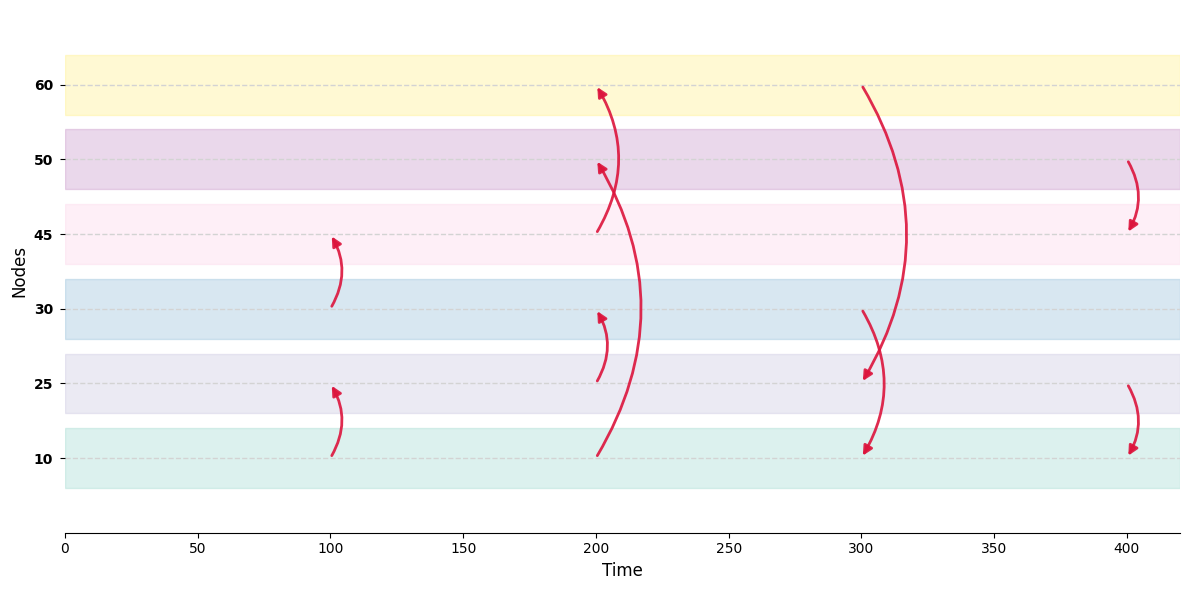

In [9]:
plot_contact_sequence([
    (10, 25, 100),
    (30, 45, 100),
    (25, 30, 200),
    (45, 60, 200),
    (10, 50, 200),
    (30, 10, 300),
    (60, 25, 300),
    (50, 45, 400),
    (25, 10, 400)
])

In [2]:
import os
import pandas as pd

file_dir = '/Volumes/traces/final_data_files/'

file_paths = [os.path.join(file_dir, f'data_{file_id}.parquet') for file_id in range(1440, 1680)]
dfs = [pd.read_parquet(file_path).sort_values(by='ts', ascending=True) for file_path in file_paths]

In [3]:
merged_df = pd.concat(dfs)

In [4]:
selected_df = merged_df[['u', 'i', 'ts']]

In [5]:
selected_df.to_parquet('/Users/ashfaqsalehin/Downloads/4_hour_data.parquet')

In [13]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

df = pd.read_csv('/Users/ashfaqsalehin/Downloads/tgbl-subreddit 2/tgbl-subreddit_edgelist.csv')

all_ids = pd.concat([df['user_id'], df['item_id']]).unique()

# Create single encoder for all nodes
node_encoder = LabelEncoder()
node_encoder.fit(all_ids)

# Encode both columns using the same encoder
df['user_id'] = node_encoder.transform(df['user_id'])
df['item_id'] = node_encoder.transform(df['item_id'])

df = df[['user_id', 'item_id', 'timestamp']].copy()
df.columns = ['u', 'i', 'ts']

df['ts'] = df['ts'] - df['ts'].min()
df = df.sort_values('ts').reset_index(drop=True)

In [14]:
df.to_csv('/Users/ashfaqsalehin/Downloads/reddit.csv', index=False)

In [18]:
df = pd.read_csv('/Users/ashfaqsalehin/Downloads/wiki.csv')

In [19]:
df['ts'].unique()

array([ 0.        , 13.20056788, 26.40113576, 39.60170364, 52.80227152,
       66.0028394 ])

In [42]:
import pandas as pd

df = pd.read_csv('/Users/ashfaqsalehin/Downloads/tgbl-flight-v2/tgbl-flight_edgelist_v2.csv')

In [43]:
df.columns

Index(['timestamp', 'src', 'dst', 'callsign', 'typecode'], dtype='object')

In [44]:
from sklearn.preprocessing import LabelEncoder

all_nodes = pd.concat([df['src'], df['dst']], ignore_index=True).unique()

# Initialize and fit label encoder on all unique nodes
label_encoder = LabelEncoder()
label_encoder.fit(all_nodes)

# Transform user_id and item_id using the same encoder
df['src'] = label_encoder.transform(df['src'])
df['dst'] = label_encoder.transform(df['dst'])

In [45]:
df = df[['src', 'dst', 'timestamp']]

In [46]:
df.columns = ['u', 'i', 'ts']
df = df.sort_values('ts').reset_index(drop=True)

original_min_ts = df['ts'].min()
if original_min_ts < 0:
    df['ts'] = df['ts'] - original_min_ts

In [47]:
df.to_csv('/Users/ashfaqsalehin/Documents/other_datasets/flight.csv', index=False)

In [48]:
df = pd.read_csv('/Users/ashfaqsalehin/Documents/other_datasets/flight.csv')
len(df)

67169570